# Trying a Neural Network to predict the rest-eigen part from the eigenvalues and the eigen-eigen part

TO-DO: Use neighboring rest-eigen contributions to predict contribution on each time slice  

In [1]:
using LmaPredict, Flux, Statistics, ProgressMeter

## Reading the data

In [3]:
const path_config = "/Users/lukasgeyer/Studium/Computational Sciences/Masterarbeit/Daten Simon/dat"
const path_plot = "../plots"

"../plots"

In [4]:
fname = readdir(path_config)[2:5001]
idx = sortperm( parse.(Int64, fname))
fname = fname[idx]

cnfgarr = Vector{LMAConfig}(undef, 0)
for f in fname
    push!(cnfgarr, get_LMAConfig(joinpath(path_config, f), "g5-g5", em="PA", bc=false))
end

## Splitting data in training and test sets

In [5]:
# Select a specific Tsource and divide data into training and test set for eigenvalues, rr re and ee components
TSRC="12"
NCNFG = length(cnfgarr)
TVALS = length(cnfgarr[1].data["rr"][TSRC]) -1
EIGVALS = minimum(length.([cnfgarr[i].data["eigvals"] for i in 1:NCNFG]))

eigvals_data = Array{Float32}(undef, EIGVALS, 4500)
rr_data = Array{Float32}(undef, TVALS, 4500)
ee_data = Array{Float32}(undef, TVALS, 4500)
re_data = Array{Float32}(undef, TVALS, 4500)

eigvals_data_test = Array{Float32}(undef, EIGVALS, 500)
rr_data_test = Array{Float32}(undef, TVALS, 500)
ee_data_test = Array{Float32}(undef, TVALS, 500)
re_data_test = Array{Float32}(undef, TVALS, 500)

for (k, dd) in enumerate(getfield.(cnfgarr, :data)[1:4500])
    eigvals_data[:,k] = copy(cnfgarr[k].data["eigvals"][1:EIGVALS])
    rr_data[:,k] = getindex(getindex(dd, "rr"), TSRC)[2:end]
    ee_data[:,k] = getindex(getindex(dd, "ee"), TSRC)[2:end]
    re_data[:,k] = getindex(getindex(dd, "re"), TSRC)[2:end]
end
for (k, dd) in enumerate(getfield.(cnfgarr, :data)[4501:5000])
    eigvals_data_test[:,k] = copy(cnfgarr[k].data["eigvals"][1:EIGVALS])
    rr_data_test[:,k] = getindex(getindex(dd, "rr"), TSRC)[2:end]
    ee_data_test[:,k] = getindex(getindex(dd, "ee"), TSRC)[2:end]
    re_data_test[:,k] = getindex(getindex(dd, "re"), TSRC)[2:end]
end

## Describing the Neural Network

As input we choose a vector containing the inverted eigenvalues $\lambda_i$ as the first $n_{\lambda}$ entries, followed by the eigen-eigen contributions $ee_i$:

v_{input} = \begin{bmatrix} \ \frac{1}{\lambda_1} \ \\[6pt] \ \frac{1}{\lambda_2} \ \\[6pt] \ \frac{1}{\lambda_3} \ \\[6pt] \vdots \\[6pt] \frac{1}{\lambda_{n_{\lambda}}} \\[6pt]
 \ ee_1 \ \\[6pt] \ ee_2 \ \\[6pt]\ ee_3 \ \\[6pt] \vdots \\[6pt]\ ee_{n_{ee}} \ \end{bmatrix}

 
 where $n_{ee}$ is the number of time samples, 47 in our case. $\\[10pt]$

Our Neural Network therefore has an input layer of size $n_{\lambda} + n_{ee}$. We then try one fully connected layer of size $2(n_{\lambda} + n_{ee})$ and a fully connected output layer of size $n_{ee}$. 

**Note:** As we do not have the same amount of eigenvalues available for each configuration, we calculate the minimum of available eigenvalues out of all configurations, such that we can use as many as possible.

**Note:** Notice the shift introduced. The rest-eigen contributions seem to be normalized when values are shifted by this factor. This helps if we introduce the softmax function in the last step of the model which normalizes the output.

In [6]:
shift = 0.0

input_length = EIGVALS + 2
output_length = 1
hidden_length = 2*input_length

input_data = Array{Matrix}(undef, 47)
for i in 1:47
    input_data[i] = [1 ./ eigvals_data; ee_data[i,:]'; rr_data[i,:]']
end

target = Array{Array}(undef, 47)
for i in 1:47
    target[i] = re_data[i,:]'
end

test_input_data = Array{Matrix}(undef, 47)
for i in 1:47
    test_input_data[i] = [1 ./ eigvals_data_test; ee_data_test[i,:]'; rr_data_test[i,:]']
end

test_target = Array{Array}(undef, 47)
for i in 1:47
    test_target[i] = re_data_test[i,:]'
end

## Defining the Networks

In [7]:
model = Chain(
    Dense(input_length => hidden_length, tanh),
    BatchNorm(hidden_length),
    Dense(hidden_length => hidden_length),
    Dense(hidden_length => output_length),
    )

Chain(
  Dense(66 => 132, tanh),               # 8_844 parameters
  BatchNorm(132),                       # 264 parameters, plus 264
  Dense(132 => 132),                    # 17_556 parameters
  Dense(132 => 1),                      # 133 parameters
)         # Total: 8 trainable arrays, 26_797 parameters,
          # plus 2 non-trainable, 264 parameters, summarysize 106.309 KiB.

In [18]:
models = [
    model = Chain(
    Dense(input_length => hidden_length, tanh),
    BatchNorm(hidden_length),
    Dense(hidden_length => output_length)
    ) |> gpu

    for i in 1:47]

47-element Vector{Chain{Tuple{Dense{typeof(tanh), MtlMatrix{Float32, Metal.MTL.MTLResourceStorageModePrivate}, MtlVector{Float32, Metal.MTL.MTLResourceStorageModePrivate}}, BatchNorm{typeof(identity), MtlVector{Float32, Metal.MTL.MTLResourceStorageModePrivate}, Float32, MtlVector{Float32, Metal.MTL.MTLResourceStorageModePrivate}}, Dense{typeof(identity), MtlMatrix{Float32, Metal.MTL.MTLResourceStorageModePrivate}, MtlVector{Float32, Metal.MTL.MTLResourceStorageModePrivate}}}}}:
 Chain(Dense(65 => 130, tanh), BatchNorm(130), Dense(130 => 1))  # 8_971 parameters, plus 260 non-trainable
 Chain(Dense(65 => 130, tanh), BatchNorm(130), Dense(130 => 1))  # 8_971 parameters, plus 260 non-trainable
 Chain(Dense(65 => 130, tanh), BatchNorm(130), Dense(130 => 1))  # 8_971 parameters, plus 260 non-trainable
 Chain(Dense(65 => 130, tanh), BatchNorm(130), Dense(130 => 1))  # 8_971 parameters, plus 260 non-trainable
 Chain(Dense(65 => 130, tanh), BatchNorm(130), Dense(130 => 1))  # 8_971 parameters, 

## Defining training input and target data

We use a batch size of 64 configurations to introduce stochastivity

In [8]:
loader = [Flux.DataLoader((input_data[i], target[i]), batchsize=64, shuffle=true) for i in 1:47]

optim = [Flux.setup(Flux.Adam(0.01), models[i]) for i in 1:47];

LoadError: UndefVarError: `models` not defined

In [9]:
loader = Flux.DataLoader((input_data[1], target[1]), batchsize=64, shuffle=true)

optim = Flux.setup(Flux.Adam(0.01), model);

## Training the Networks

The network sees the whole data set 1000 times. As loss function we use standard MSE.

In [19]:
epochs = 10_000

losses = []

@showprogress for epoch in 1:epochs
    for (x, y) in loader
        loss, grads = Flux.withgradient(model) do m
            y_hat = m(x)
            Flux.mae(y_hat, y)
        end
        #println("epoch: $epoch")
        #println("loss: $loss")
        Flux.update!(optim, model, grads[1])
        push!(losses, loss)
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:03:35


In [26]:
epochs = 50

losses = zeros(epochs,47)

for (i,model) in enumerate(models)
    for epoch in 1:epochs
        for (x, y) in loader[i]
            loss, grads = Flux.withgradient(model) do m
                y_hat = m(x)
                Flux.mae(y_hat, y)
            end
            #println("epoch: $epoch")
            #println("loss: $loss")
            Flux.update!(optim[i], model, grads[1])
        end
        #losses[i,epoch] = loss
    end
end

LoadError: MethodError: no method matching getindex(::MLUtils.DataLoader{Tuple{MtlMatrix{Float32, Metal.MTL.MTLResourceStorageModePrivate}, MtlMatrix{Float32, Metal.MTL.MTLResourceStorageModePrivate}}, Random._GLOBAL_RNG, Val{nothing}}, ::Int64)

## Checking loss dynamics in training

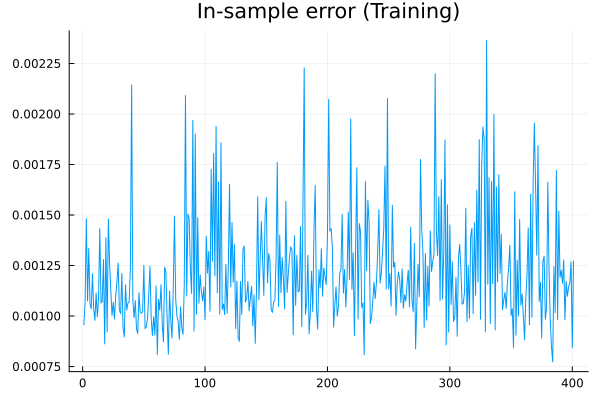

In [20]:
using Plots

plot(losses[end-400:end], title="In-sample error (Training)", legend=:false)

## Checking out-of-sample results

In [21]:
out_of_sample_predictions = model(test_input_data[1]);

**Note:** Notice that I introduced a constant offset of $-0.021$ (which is arbitrary for now). There needs to be further investigation going into this offset!

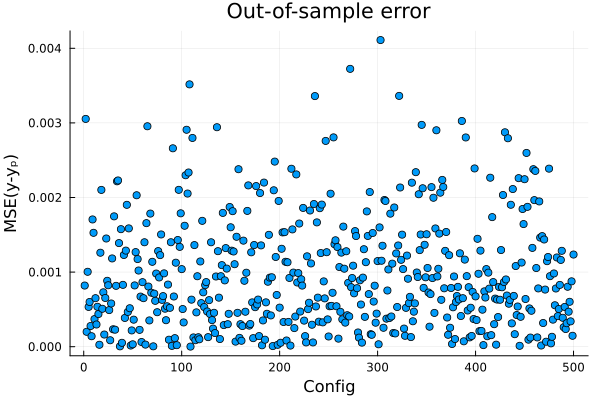

In [22]:
scatter([Flux.mae(out_of_sample_predictions[:,i], test_target[1][:,i]) for i in 1:500], title="Out-of-sample error", legend=:false)

xlabel!("Config")
ylabel!("MSE(y-yₚ)")

In [ ]:
using Plots

offset = - 0

l = @layout [a b c; d e f; g h i]

c1 = rand([i for i in 1:500])
p1 = scatter(test_target[:,c1], label="Actual")
scatter!(p1, out_of_sample_predictions[:,c1] .+ offset, label="Prediction", legend=:top)

c2 = rand([i for i in 1:500])
p2 = scatter(test_target[:,c2], label="Actual")
scatter!(p2, out_of_sample_predictions[:,c2] .+ offset, label="Prediction", legend=:top)

c3 = rand([i for i in 1:500])
p3 = scatter(test_target[:,c3], label="Actual")
scatter!(p3, out_of_sample_predictions[:,c3] .+ offset, label="Prediction", legend=:top, )

c4 = rand([i for i in 1:500])
p4 = scatter(test_target[:,c4], label="Actual")
scatter!(p4, out_of_sample_predictions[:,c4] .+ offset, label="Prediction", legend=:top)

c5 = rand([i for i in 1:500])
p5 = scatter(test_target[:,c5], label="Actual")
scatter!(p5, out_of_sample_predictions[:,c5] .+ offset, label="Prediction", legend=:top)

c6 = rand([i for i in 1:500])
p6 = scatter(test_target[:,c6], label="Actual")
scatter!(p6, out_of_sample_predictions[:,c6] .+ offset, label="Prediction", legend=:top)

c7 = rand([i for i in 1:500])
p7 = scatter(test_target[:,c7], label="Actual")
scatter!(p7, out_of_sample_predictions[:,c7] .+ offset, label="Prediction", legend=:top)

c8 = rand([i for i in 1:500])
p8 = scatter(test_target[:,c8], label="Actual")
scatter!(p8, out_of_sample_predictions[:,c8] .+ offset, label="Prediction", legend=:top)

c9 = rand([i for i in 1:500])
p9 = scatter(test_target[:,c9], label="Actual")
scatter!(p9, out_of_sample_predictions[:,c9] .+ offset, label="Prediction", legend=:top)

plot(p1, p2, p3, p4, p5, p6, p7, p8, p9, layout = l, size=(1200,1000), dpi=1000, markerstrokewidth = 0)
#savefig(joinpath(path_plot, "neural_network_test.pdf"))